# The Quasi Static Step
---
Many tribology models involve modelling the same surfaces in contact with some relative movement, or a ramping of load. While the contact pressures and areas are changing during these simulations, the solution to the contact mechanics problem is static in each time step. In SlipPY the QuasiStaticStep is used to efficiently solve these problems.

In this notebook we will work through an example of two surfaces coming into contact, we will generate a load displacement curve for the surfaces, but a similar workflow can be used to model sliding contacts.

Much of the modelling process for this simulation is the same as a static simulation, however we will also need to use SlipPY’s output request system to write intermediate results to file during the simulation.

---
The modelling process is summarised in the bullet points below:
-	Generate or read in surface profiles
-	Add materials to the surfaces
-	Make a contact model object to coordinate the solution
-	Make a QuasiStaticStep
-	Add sub-models and Outputs
-	Solve the model
-	Post process the results

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import slippy.surface as s
import slippy.contact as c

## Making the surface profiles
In this example we will use a randomly rough surface added to a cylinder as our first surface and a simple flat surface for our second surface. This process is extremely simple in SlipPY, there are also many other alternatives for random roughnesses and base geometry.

C:\Users\mea08\code\SlipPY\slippy\surface\FFTBased.py:338: RuntimeWarning: divide by zero encountered in power
  psd = rho ** (-2 * (hurst_exponent + 1))


<AxesSubplot:title={'center':'Surface profile'}, xlabel='x', ylabel='y'>

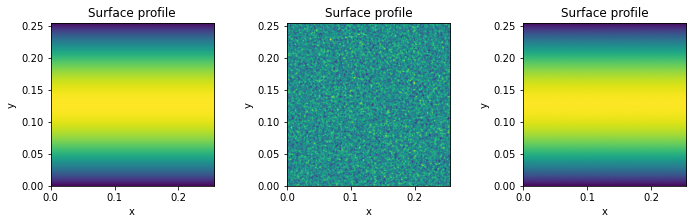

In [2]:
cylinder = s.RoundSurface((1,np.inf,1), shape=(256,256), grid_spacing=0.001)
roughness = s.HurstFractalSurface(1, 0.2, 1000, shape=(256, 256), grid_spacing=0.001, 
                                  generate = True)

combined = cylinder + roughness * 0.00001

flat = s.FlatSurface(shape=(256, 256), grid_spacing=0.001, generate = True)
# Plotting
fig, axes = plt.subplots(1, 3, figsize = (12, 3))
cylinder.show(ax=axes[0]); roughness.show(ax=axes[1]); combined.show(ax=axes[2])

## Making and asigning materials to the surface
Next, we have to make materials for the surfaces and assign them to the surface. Here we will use an elastic material, but we will account for some of the plasti behaviour by setting a maximum allowable pressure.

In [3]:
yield_stress = 3*np.exp(0.736*0.3)*705e6
material = c.Elastic('steel', properties = {'E':200e9, 'v':0.3}, max_load = yield_stress)
combined.material = material
flat.material = material

## Making a contact model and the step
Now we have our surfaces and materials we need a contact model object to keep all the information together and coordinate execution of the steps. The model anme will be used to name the output and log files.

We also need to make a new step in this model which will describe the problem we are trying to solve. Here we will ramp up the pressure between the surfaces up to a maximum nominal pressure of 300MPa. We will do this in 50 steps. There is no time dependent behaviour in this step so we can set the no_time argument to True, this will save computation time by caching results from previous time steps.

As we are modelling a cylinder on flat, we can also specify that the solution should be periodic along the x axis but not along the y axis.

After making the model and the step, we need to add the step to the model.

In [4]:
my_model = c.ContactModel('qss_test', combined, flat)

max_int = 0.002
n_time_steps = 20
my_step = c.QuasiStaticStep('loading', n_time_steps, no_time=True, 
                            interference = [max_int*0.001,max_int],
                            periodic_geometry=True, periodic_axes = (False, True))
my_model.add_step(my_step)

## Adding sub-models
In this simulation we have set a maximum load allowable for the materials, this means that where the load on the surfaces is at the maximum they are allowed to penetrate each other. To remove this material we can use a wear model:

In [5]:
wear_submodel = c.sub_models.WearElasticPerfectlyPlastic('wear_l', 0.5, True)
my_step.add_sub_model(wear_submodel)

C:\Users\mea08\code\SlipPY\slippy\contact\sub_models\epp_wear.py:61: UserWarning: Proportion surface 1 + proportion surface 2 is greater than 1, more wear will be applied than the overlap between the surfaces, this will result in unphysical results
  warnings.warn("Proportion surface 1 + proportion surface 2 is greater than 1, more wear will be applied"


## Adding output requests to the model
At this point we could solve the model, however we would only be able to view the final output which is not what we want. We can tell SlipPY what we want to save on each time step by adding an output request to the steps we want to save data from. At this point we could also add submodels such as tangential behaviour or wear models, however we do not need these for our model.

We can view a list of avalible outputs by checking the 'provides' attribute of our step. If we had added submodels we could also check their 'provides' attribute to see what outputs they add. In addition to outputs provided directly by the step or submodel we can also output attributes of either surface.

In [6]:
print(my_step.provides)

{'total_displacement', 'total_normal_load', 'just_touching_gap', 'converged', 'time_step', 'time', 'new_step', 'off_set', 'surface_1_displacement', 'loads', 'surface_1_points', 'interference', 'surface_2_points', 'gap', 'surface_2_displacement', 'contact_nodes'}


In [7]:
output_request = c.OutputRequest('Output-1', 
                                 ['interference', 'total_normal_load', 
                                  'loads', 'total_displacement',
                                  'converged'])
my_step.add_output(output_request)

# Solving the model
Now we are ready to solve the model!

In [8]:
final_result = my_model.solve()

C:\Users\mea08\code\SlipPY\slippy\contact\influence_matrix_utils.py:614: UserWarning: Bound constrained conjugate gradient iterations failed to converge
  warnings.warn("Bound constrained conjugate gradient iterations failed to converge")


## Plotting the results
If we want to plot the results, we need to read the output files back in. Slippy provides a convinient tool for this:

In [9]:
output = c.OutputReader('qss_test')

Text(0, 0.5, 'Interference (m)')

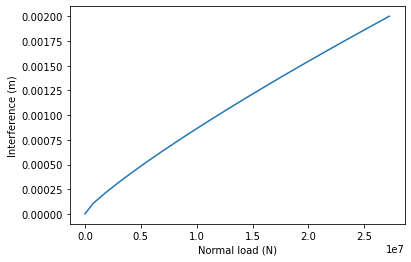

In [10]:
interference = list(output['interference'].values())
total_loads = list(output['total_normal_load'].values())
ax = plt.plot(total_loads, interference)
plt.xlabel('Normal load (N)'); plt.ylabel('Interference (m)')

In [11]:
from ipywidgets import interact, IntSlider

ext = [0, flat.extent[0], 0, flat.extent[1]]

def plot_loads_displacements(time_step=1):
    time_step = output.time_points[time_step]
    loads = output['loads_z'][time_step]
    displacements = output['total_displacement_z'][time_step]
    fig, (ax1, ax2) = plt.subplots(figsize=(13, 5), ncols=2)
    pos1 = ax1.imshow(loads, extent=ext); pos2 = ax2.imshow(displacements, extent=ext)
    fig.colorbar(pos1, ax=ax1); fig.colorbar(pos2, ax=ax2)
    _ = ax1.set_title('Surface pressures'); _ = ax2.set_title('Surface displacement')
    
interact(plot_loads_displacements, 
         time_step=IntSlider(min=1, max=n_time_steps-1, step=1, value=n_time_steps-1))

interactive(children=(IntSlider(value=19, description='time_step', max=19, min=1), Output()), _dom_classes=('w…

<function __main__.plot_loads_displacements>